In [ ]:
cd(@__DIR__)
import Pkg
Pkg.activate(".")
Pkg.instantiate()

# Modelling Disease Transmission

## Introduction
The COVID19 [pandemic](https://en.wikipedia.org/wiki/COVID-19_pandemic) has thrown into stark relief the need for reliable data, testing, and disease modelling, and shown how our individual actions can affect public health.

Computational modelling has been a powerful tool for informing policy, and ultimately steering individual behaviour decisions at large nationwide scales.

There are a number of approaches that can be taken when it comes to modelling infectious diseases. 

Arguably the most common method is to compartmentalize the population into a few segments (e.g. those who could catch a disease, those who have the disease currently, and those who have recovered) then follow the whole system as it evolves. This is a *top down* approach.

Another way to look at it is to think from the *bottom up* ... instead of modelling whole interacting populations, we can instead define individual *agents*, each of which can then interact, and e.g. transmit a disease, recover and so on.

Let's take a look at both ...


## Model 1: top-down, differential equations
We can think of this [model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model_2) as being something like a chemistry set -- where we start with a population of susceptible people (S), mix in a small amount of infectedness (I), then wait a while to see what proportion get infected, and then what proportion will recover.

![](pics/sir_nb_diag_01.png)
*The SIR model can be thought of as a chemical mixing interaction*

This can all be described by a few differential equations...

$\dot S(t) = - \beta S(t)I(t)$

*The rate of change of the susceptible proportion of the population at time *t* is: the proportion susceptible (at time *t*) times the proportion infected (at time *t*), times some number $\beta$ (which tells you how infectious the disease is -- a more infectious disease has higher $\beta$)*

$\dot R(t) = \gamma I(t)$

*The rate of change of the proportion of the population who have recovered at time *t* is the proportion who are infected times some number $\gamma$ -- the larger $\gamma$ is, the quicker people recover.*

<!-- 3. $\dot I(t) = \beta S(t)I(t) - \gamma I(t)$ -->
-$\dot I(t) = \dot S(t) + \dot R(t)$

*The rate of change of the infected proportion of the population at time *t* is: the sum of the rates of change of the susceptible and recovered population (times -1)*

While it's easy enough to write these equations down, solving them can be non-trivial.



### Julia code

* let's start by firing up a Julia environment and load the packages needed to solve our differential equations and plot the results.

In [15]:
# cd(@__DIR__)
# import Pkg
# Pkg.activate(".")
# Pkg.instantiate()
using DifferentialEquations, ParameterizedFunctions, StatsPlots

  Activating project at `~/Documents/Documents - spectra/Dev/Julia/abm-dsap/code/01-basic-SIR`


* next, we can define our differential equation model, as well as the parameters ($\beta$ and $\gamma$) and starting values (here we define 1% of the population as infected at the start) we need.

In [16]:
SIR_diffeq = @ode_def begin
    dS = -β*S*I
    dI = (β*S*I) - (γ*I)
    dR = γ*I
end β γ

parameters = [0.4, 0.025] # β and γ parameters
init_I = 0.01 # 1% of population initially infected
init_SIR = [1 - init_I, init_I, 0.0] # initial values for S, I, R (must sum to 1)
tspan = (0.0, 200.0) # start and stop time points

(0.0, 200.0)

* time to run the model!

In [17]:
SIR_diff_problem = ODEProblem(SIR_diffeq, init_SIR, tspan, parameters) # define the problem
SIR_diff_output = solve(SIR_diff_problem) # solve!

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 31-element Vector{Float64}:
   0.0
   0.13276835238446313
   0.7027816317038449
   1.6101433779685315
   2.676298451870517
   4.011622962775114
   5.566210722666843
   7.385120228422693
   9.492440778234092
  11.938188768328123
   ⋮
  62.06289504756632
  71.48257772197385
  84.63083401491835
 103.33655263819979
 123.06128698687267
 146.21275477005923
 170.9336848220296
 197.85670533903567
 200.0
u: 31-element Vector{Vector{Float64}}:
 [0.99, 0.01, 0.0]
 [0.9894612225430497, 0.010504754469778353, 3.402298717191829e-5]
 [0.9868260456037291, 0.01297325659556274, 0.0002006978007081579]
 [0.981322342944146, 0.01812741010452095, 0.0005502469513330387]
 [0.972084860392494, 0.026773774856155667, 0.0011413647513503046]
 [0.9543775516931956, 0.043332099560064945, 0.0022903487467394222]
 [0.9207339738473457, 0.07473266941857262, 0.004533356734081717]
 [0.854291

* finally, let's plot everything...

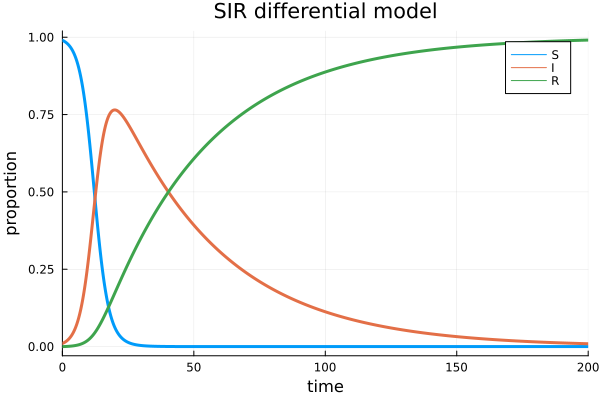

In [18]:
plot(SIR_diff_output, xlabel="time", ylabel="proportion", title = "SIR differential model", lw = 3)

* 


## Model 2: bottom-up, agent-based
Instead of thinking of our population as a perfectly mixed "fluid", we can think of it in a more person-centric way -- as a collection of interacting [agents](https://en.wikipedia.org/wiki/Agent-based_model).

![](pics/sir_nb_diag_02.png)
*Agent based models consist of interacting agents, each with their own individual properties*

### Julia code
We can make use of the [Agents.jl](https://juliadynamics.github.io/Agents.jl/stable/) library, and set up an agent based model similar to the SIR differential equation model we already have.

In [19]:
using Agents, DataFrames, Distributions, Random

* first we define our *agents* -- they have two simple properties: *id* (a number so the model can identify each agent) and *status* (which will take the values *S*, *I* or *R* depending on the agent's disease status)

In [20]:
mutable struct Person <: AbstractAgent
    id::Int64
    status::Symbol
end

* now we write function that can set up the model, by setting the model parameters and adding agents to the model.

In [21]:
function init_model(β::Float64, c::Float64, γ::Float64, N::Int64, I0::Int64)
    properties = Dict(:β=>β, :c=>c, :γ=>γ)
    model = ABM(Person; properties=properties)
    # set I0 agents to be infected, and the rest (up to N) as susceptible
    for i in 1:N
        if i <= I0
            s = :I # these are symbols, as defined in the Person struct
        else
            s = :S
        end
        # instatiate a "Person" agent with appropriate id and status, and add to model
        p = Person(i, s)
        p = add_agent!(p, model)
    end
    return model
end

init_model (generic function with 1 method)

* next we set up the logic for transmitting the disease ie:
    * if our agent is susceptible (*S*) then
        * for each contact with an infected (*I*) agent, decide (based on disease infectivity) whether they transmit the disease

In [22]:
function transmit!(agent, model, N)
    agent.status != :S && return # short-circuit "and" evaluation here means that if status is not :S, function returns here, ie this agent cannot be infected 
    ncontacts = rand(Poisson(model.properties[:c])) # how many contacts has our agent made in time δt?
    all_agent_ids = 1:N
    agent_ids = all_agent_ids[all_agent_ids .!= agent.id] # agent ids excluding our agent itself

    for i in 1:ncontacts
        alter = model[rand(agent_ids)]
        if alter.status == :I && (rand() ≤ model.properties[:β])
            # An infection occurs
            agent.status = :I
            break
        end
    end
end

transmit! (generic function with 1 method)

* now, we do something similar for whether an agent recovers or not (although this time the function is simpler as it doesn't depend on the presence or status of other agents)

In [23]:
function recover!(agent, model)
    agent.status != :I && return
    if rand() ≤ model.properties[:γ]
            agent.status = :R
    end
end

recover! (generic function with 1 method)

* next (nearly there!) we define what the agents do fo reach time step -- here they just transmit and/or then recover. (we also add a few functions that will be helpful when it comes to plotting the model output data)

In [24]:
function agent_step!(agent, model)
    transmit!(agent, model, N)
    recover!(agent, model)
end

susceptible(x) = count(i == :S for i in x)
infected(x) = count(i == :I for i in x)
recovered(x) = count(i == :R for i in x)

recovered (generic function with 1 method)

* now we define all the parameters and starting values that we will use in our model.

In [25]:
Random.seed!(1234)
Δt = 0.1 # time step width
nsteps = 400 
tf = nsteps * Δt # time at end of simulation
t = 0:Δt:tf # vector of time points

γ = 0.025 # prob of recovery for each time step (if infected)
β = 0.4 # prob of a contact causing infection
c = 0.3 # poissonian expectation value of number of contacts in time step

N = 1000 # total agents
I0 = 10 # initial infected

10

* now we can run our agent-base model!

In [26]:
abm_model = init_model(β, c, γ, N, I0) # initiate model
to_collect = [(:status, f) for f in (susceptible, infected, recovered)] # data to collect (counts of S, I, R)
abm_data, _ = run!(abm_model, agent_step!, nsteps; adata = to_collect) # run model and collect data; returned as abm_data
abm_data[!, :t] = t # insert the time vector

0.0:0.1:40.0

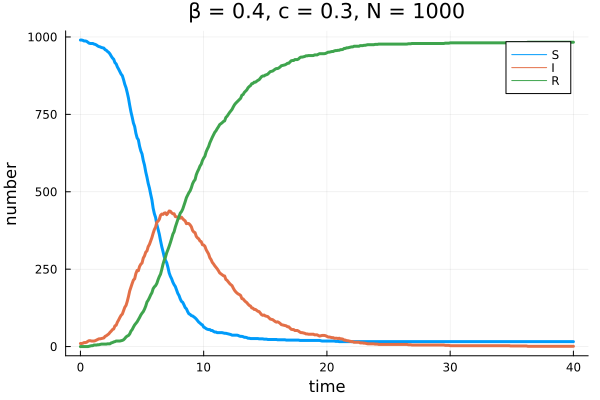

In [27]:
title = "β = " * string(β) * ", c = " * string(c) * ", N = " * string(N) 
p = plot(t, abm_data[:, 2], label="S", xlab="time", ylabel="number", title = title, lw=3)
p = plot!(t,abm_data[:, 3], label="I", lw = 3)
p = plot!(t,abm_data[:, 4], label="R", lw = 3)